## How to use contours to view global data

We will look at a couple of datasets and see how best to view them with contours instead of rendering everything as a global image. We have global strain rate and global sea-floor age. Both datasets have holes in them !

In [1]:
%pylab inline

import gdal
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
global_extent     = [-180.0, 180.0, -90.0, 90.0]
globalmarble      = gdal.Open("../../Data/Resources/BlueMarbleNG-TB_2004-06-01_rgb_3600x1800.TIFF")
globalmarble_img  = globalmarble.ReadAsArray().transpose(1,2,0)
globaletopo       = gdal.Open("../../Data/Resources/color_etopo1_ice_low.tif")
globaletopo_img   = globaletopo.ReadAsArray().transpose(1,2,0)

del(globalmarble)
del(globaletopo)

In [3]:
# Global strain rate data - from Unavco

strainrate_extent=[-180,180,-68,80]
strainrate = numpy.loadtxt("../../Data/Resources/sec_invariant_strain_0.2.dat")
strainrate_data = strainrate.reshape(741,1800,3)  # I had to look at the data to work this out !
# strainrate_img  = strainrate_data[:,:,2]


/usr/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


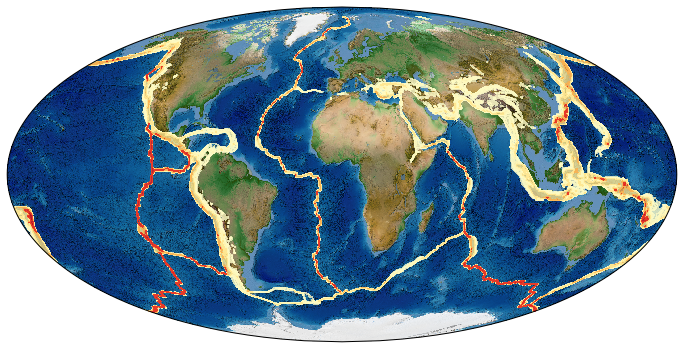

In [4]:
projection1 = ccrs.Orthographic(central_longitude=140.0, central_latitude=0.0, globe=None)
projection2 = ccrs.Mollweide()

base_projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax = plt.subplot(111, projection=projection2)
ax.set_global()

ax.imshow(globaletopo_img, origin='upper', transform=base_projection, extent=global_extent, zorder=0)
ax.imshow(globalmarble_img, origin='upper', transform=base_projection, extent=global_extent, alpha=0.5, zorder=1)

ax.contourf(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
         levels=[20,30,40,50,60,70,80,90,100,300,500,1000], linewidth=0.0,
         transform=base_projection,  cmap="YlOrRd", zorder=2, alpha=0.8, extent=strainrate_extent)


plt.show()

In [5]:
# Seafloor age data and global image - data from Earthbyters

# The data come as ascii lon / lat / age tuples with NaN for no data. 
# This can be loaded with ...

# age = numpy.loadtxt("Resources/global_age_data.3.6.xyz")
# age_data = age.reshape(1801,3601,3)  # I looked at the data and figured out what numbers to use
# age_img  = age_data[:,:,2]

# But this is super slow, so I have just stored the Age data on the grid (1801 x 3601) which we can reconstruct easily

datasize = (1801, 3601, 3)
age_data = np.empty(datasize)

ages = np.load("../../Data/Resources/global_age_data.3.6.z.npz")["ageData"]

lats = np.linspace(90, -90, datasize[0])
lons = np.linspace(-180.0,180.0, datasize[1])

arrlons,arrlats = np.meshgrid(lons, lats)

age_data[...,0] = arrlons[...]
age_data[...,1] = arrlats[...]
age_data[...,2] = ages[...]


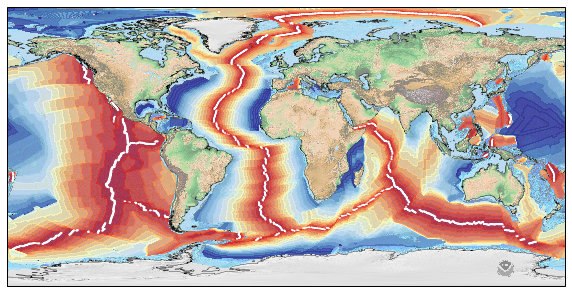

In [6]:
import cartopy.feature as cfeature

projection = ccrs.PlateCarree()

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(0.0,0.0,0.0),
                           facecolor="none")

globaletopo_img2 = globaletopo_img.copy()
globaletopo_img2[...] = 255 * (globaletopo_img[...] / 255.0) ** 2.0

fig = plt.figure(figsize=(10, 10), facecolor="none", edgecolor="none")
ax = plt.axes(projection=projection)
ax.imshow(globaletopo_img2, origin='upper', transform=base_projection, extent=global_extent, zorder=0, alpha=0.5)
ax.add_feature(coastline, linewidth=0.33, edgecolor="Black", zorder=1)

cf = contourf(age_data[:,:,0], age_data[:,:,1], age_data[:,:,2], 
         levels = arange(0.5,250,10), vmin=0, vmax=150,
         transform=base_projection,  cmap="RdYlBu",zorder=2, alpha=0.75)

contour(age_data[:,:,0], age_data[:,:,1], age_data[:,:,2], levels = (0.1,0.5), colors="white", transform=base_projection)


# Want to keep the image ? Do something like this:
# plt.savefig("GlobalAgeMap.png", dpi=300, frameon=False, edgecolor="none", facecolor="none", bbox_inches='tight', pad_inches=0.0)
plt.show()

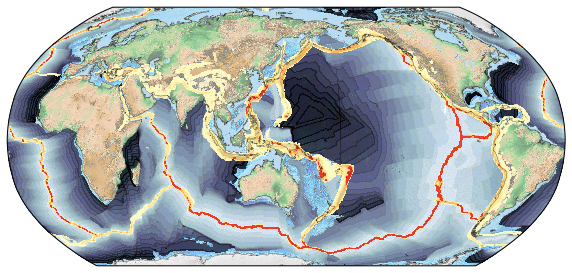

In [7]:
projection = ccrs.Robinson(central_longitude=145)

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(0.2,0.2,0.2),
                           facecolor="none")


fig = plt.figure(figsize=(10, 10), facecolor="none", edgecolor="none")
ax = plt.axes(projection=projection)

ax.imshow(globaletopo_img2, origin='upper', transform=base_projection, extent=global_extent, zorder=0, alpha=0.5)


cf = contourf(age_data[:,:,0], age_data[:,:,1], age_data[:,:,2], 
         levels = arange(0.5,250,10), vmin=0, vmax=150,
         transform=base_projection,  cmap="bone_r",zorder=2, alpha=0.75)


contour(age_data[:,:,0], age_data[:,:,1], age_data[:,:,2], levels = (0.1,0.5), colors="white", transform=base_projection)

ax.contourf(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
         levels=[20,30,40,50,60,70,80,90,100,300,500,1000], linewidth=0.0,
         transform=base_projection,  cmap="YlOrRd", zorder=2, alpha=0.8, extent=strainrate_extent)

ax.add_feature(coastline, linewidth=0.33, zorder=3)

plt.savefig("GlobalAgeAndStrainRate.png", dpi=300, frameon=False, edgecolor="none", facecolor="none", bbox_inches='tight', pad_inches=0.0)




In [8]:
# This is how I saved the Earthbyte file from the original xyz format
# np.savez_compressed("Resources/global_age_data.3.6.z.npz",ageData=age_data[...,2])